### Импорты


In [ ]:
%pip install pandas

Note: you may need to restart the kernel to use updated packages.


In [ ]:
%pip install pycocotools

Note: you may need to restart the kernel to use updated packages.


In [ ]:
%pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [ ]:
%pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [ ]:
%pip install torchmetrics

Note: you may need to restart the kernel to use updated packages.


In [ ]:
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [ ]:
%pip install albumentations

Note: you may need to restart the kernel to use updated packages.


In [ ]:
%pip install scikit-multilearn

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import io
import cv2
import math
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms, models
from torchvision.models.feature_extraction import create_feature_extractor, get_graph_node_names
from torchvision.ops import nms, box_iou
from torchvision.models.detection.anchor_utils import AnchorGenerator
from torchmetrics.detection import MeanAveragePrecision
from tqdm import tqdm
from PIL import Image
from matplotlib import pyplot as plt

### Загрузка данных


### Clinical Bacteria DataSet


This dataset comprises Gram-stained bacteria images obtained using M-ROSE from lower respiratory tract specimens of patients with lung infection from 2018 to 2022 at the Chinese PLA General Hospital


A total of 4,833 cocci and 6,991 bacilli were manually labeled and differentiated into negative and positive categories


Accumulated annotation a total of 3371 Gram-negative cocci (G-cocci), 1462 Gram-positive cocci (G+cocci), 5799 Gram-negative bacilli (G-bacilli), and 1192 Gram-positive bacilli (G+bacilli )


In [ ]:
def load_yolo_dataset(image_folder, label_folder):
    """
    Загружает изображения и разметку YOLO в pandas DataFrame.

    Args:
        image_folder (str): Путь к папке с изображениями.
        label_folder (str): Путь к папке с файлами разметки YOLO.

    Returns:
        pd.DataFrame: DataFrame с колонками 'image' (байты изображения)
                      и 'objects' (список словарей объектов).
    """
    data = []
    image_files = sorted([f for f in os.listdir(
        image_folder) if f.endswith(('.jpg', '.jpeg', '.png'))])

    for image_file in tqdm(image_files):
        image_name_without_ext = os.path.splitext(image_file)[0]
        label_file_name = f"{image_name_without_ext}.txt"
        label_file_path = os.path.join(label_folder, label_file_name)
        image_file_path = os.path.join(image_folder, image_file)

        if os.path.exists(label_file_path):
            with open(image_file_path, 'rb') as f:
                image_bytes = f.read()

            objects = []
            labels = []
            with open(label_file_path, 'r') as f:
                for line in f:
                    parts = list(map(float, line.strip().split()))
                    obj = {
                        'class': int(parts[0]),
                        'bbox': parts[1:]
                    }
                    objects.append(obj)
                    labels.append(int(parts[0]))

            data.append(
                {'image': image_bytes, 'objects': objects, 'labels': labels})
        else:
            print(f"Warning: No label file found for {image_file}")

    return pd.DataFrame(data)

In [ ]:
images_dir = "./Bacteria/images"
labels_dir = "./Bacteria/labels"

df = load_yolo_dataset(images_dir, labels_dir)
print(df.head())
print(f"DataFrame создан с {len(df)} записями.")

100%|██████████| 6005/6005 [00:00<00:00, 10361.64it/s]

                                               image  \
0  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...   
1  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...   
2  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...   
3  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...   
4  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...   

                                             objects        labels  
0  [{'class': 3, 'bbox': [0.614844, 0.048438, 0.1...           [3]  
1  [{'class': 0, 'bbox': [0.700781, 0.657813, 0.0...           [0]  
2  [{'class': 2, 'bbox': [0.227344, 0.841406, 0.1...           [2]  
3  [{'class': 0, 'bbox': [0.757812, 0.446094, 0.0...     [0, 2, 2]  
4  [{'class': 2, 'bbox': [0.285156, 0.860156, 0.1...  [2, 2, 2, 2]  
DataFrame создан с 6005 записями.


In [ ]:
# Вспомогательные функции для отрисовки данных
def add_bbox(image, box, label='', color=(0, 0, 0), txt_color=(0, 0, 0), img_width=640, img_height=640, normalized=True):
    if normalized:
        center_x = box[0] * img_width
        center_y = box[1] * img_height
        width = box[2] * img_width
        height = box[3] * img_height
    else:
        center_x = box[0]
        center_y = box[1]
        width = box[2]
        height = box[3]

    p1 = (int(center_x - width / 2), int(center_y - height / 2))
    p2 = (int(center_x + width / 2), int(center_y + height / 2))

    cv2.rectangle(image, p1, p2, color, thickness=2, lineType=cv2.LINE_AA)
    if label:
        w, h = cv2.getTextSize(label, 0, fontScale=1, thickness=1)[0]
        outside = p1[1] - h >= 0
        p2 = p1[0] + w, p1[1] - h if outside else p1[1] + h
        cv2.rectangle(image, p1, p2, color, -1, cv2.LINE_AA)
        cv2.putText(image,
                    label, (p1[0], p1[1] if outside else p1[1] + h),
                    fontFace=0,
                    fontScale=1,
                    color=txt_color,
                    thickness=2,
                    lineType=cv2.LINE_AA)
    return image


def plot_examples(df, class_names, class_colors, indices=None, num_examples=6, row_figsize=(12, 3)):
    if indices is None:
        indices = np.random.choice(len(df), size=num_examples, replace=False)
    else:
        num_examples = len(indices)

    ncols = min(num_examples, 3)
    nrows = math.ceil(num_examples / 3)
    figure, axes = plt.subplots(nrows, ncols, figsize=(
        row_figsize[0], row_figsize[1] * nrows), tight_layout=True)
    axes = axes.reshape(-1)

    for ix, ax in zip(indices, axes):
        row = df.iloc[ix]
        image = np.array(Image.open(io.BytesIO(row['image'])))

        for object in row['objects']:
            image = add_bbox(
                image, object['bbox'], label=class_names[object['class']], color=class_colors[object['class']])

        ax.imshow(image)
        ax.set_title(f"Image index: {ix}")
        ax.set_xticks([])
        ax.set_yticks([])

In [ ]:
class_names = ['negative cocci', 'positive cocci',
               'negative bacilli', 'positive bacilli']
class_colors = [(255, 0, 0), (0, 0, 255), (255, 0, 0), (0, 0, 255)]

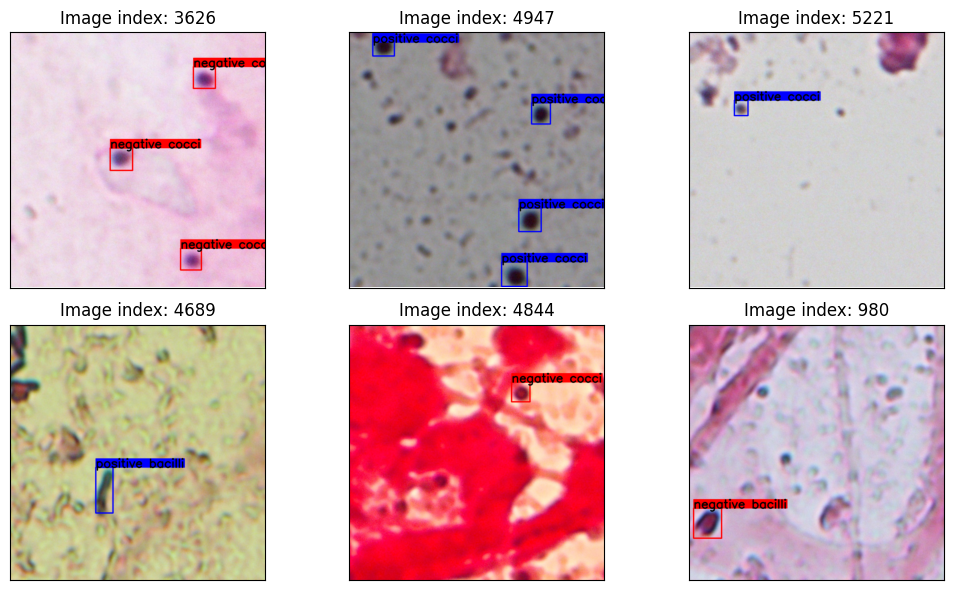

In [ ]:
plot_examples(df, class_names, class_colors)

### Предобработка данных


In [ ]:
class BacteriaDataset(Dataset):
    def __init__(self, dataframe, transform=None, train=True):
        self.data = dataframe
        self.transform = transform
        self.train = train

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        """Загружает изображение и разметку для объекта с индексом `idx`.

        Args:
            idx (int): Индекс объекта данных.

        Returns:
            Tuple[torch.Tensor, Dict[str, torch.Tensor]]: Кортеж, содержащий:
                - image (torch.Tensor): Тензор изображения.
                - target (Dict[str, torch.Tensor]): Словарь, содержащий:
                    - 'bbox' (torch.Tensor): Тензор ббоксов в формате (center_x, center_y, w, h).
                    - 'labels' (torch.Tensor): Тензор классов для каждого ббокса.
        """
        target = {}

        row = self.data.iloc[idx]
        image = Image.open(io.BytesIO(row["image"]))
        image = np.array(image)

        labels = [obj['class'] for obj in row['objects']]
        bbox = [obj['bbox'] for obj in row['objects']]

        if self.transform is not None:
            transformed = self.transform(
                image=image, bboxes=bbox, labels=labels)
            image, bbox, labels = transformed["image"], transformed["bboxes"], transformed["labels"]
        else:
            image = transforms.ToTensor()(image)

        if not self.train:
            target['boxes'] = torch.tensor(
                np.array(bbox) * 640, dtype=torch.float32)
        else:
            target['boxes'] = torch.tensor(np.array(bbox), dtype=torch.float32)
        target['labels'] = torch.tensor(labels, dtype=torch.int64)
        return image, target


def collate_fn(batch):
    batch = tuple(zip(*batch))
    images = torch.stack(batch[0])
    return images, batch[1]

Аугментации


In [ ]:
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

train_transform = A.Compose(
    [
        A.Normalize(mean=mean, std=std),
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.2),
        ToTensorV2(),
    ],
    bbox_params=A.BboxParams(format='yolo', label_fields=['labels'])
)

test_transform = A.Compose(
    [
        A.Normalize(mean=mean, std=std),
        ToTensorV2(),
    ]
)

In [ ]:
from skmultilearn.model_selection import IterativeStratification


def stratified_train_test_split(df, test_size=0.2, random_state=None):
    # Create multi-hot encoded labels
    all_sign_ids = sorted(
        set(sign_id for sublist in df['labels'] for sign_id in sublist))
    y = np.zeros((len(df), len(all_sign_ids)), dtype=int)

    for i, sign_ids in enumerate(df['labels']):
        for sign_id in sign_ids:
            col_idx = all_sign_ids.index(sign_id)
            y[i, col_idx] = 1

    stratifier = IterativeStratification(
        n_splits=2,
        order=1,
        sample_distribution_per_fold=[1-test_size, test_size],
        random_state=random_state
    )
    test_indices, train_indices = next(stratifier.split(df.index.values, y))

    return df.iloc[train_indices], df.iloc[test_indices]


def verify_stratification(df_train, df_test):
    # Count class occurrences
    all_sign_ids = sorted(set(sign_id for sublist in pd.concat([df_train, df_test])['labels']
                          for sign_id in sublist))

    results = []
    for sign_id in all_sign_ids:
        train_count = sum(signs.count(sign_id) for signs in df_train['labels'])
        test_count = sum(signs.count(sign_id) for signs in df_test['labels'])
        total = train_count + test_count

        if total > 0:
            train_pct = (train_count / total) * 100
            test_pct = (test_count / total) * 100
            results.append(
                (sign_id, f"{train_pct:.1f}% / {test_pct:.1f}%", train_count, test_count))

    # Create comparison report
    report = pd.DataFrame(results,
                          columns=['labels', 'train% / test%', 'train_count', 'test_count'])

    print("Stratification Report:")
    print(report.to_string(index=False))

In [ ]:
df_train, df_valid = stratified_train_test_split(df)

In [ ]:
verify_stratification(df_train, df_valid)

Stratification Report:
 labels train% / test%  train_count  test_count
      0  79.0% / 21.0%         2663         708
      1  80.4% / 19.6%         1176         286
      2  80.2% / 19.8%         4653        1146
      3  79.4% / 20.6%          946         246


In [ ]:
train_dataset = BacteriaDataset(df_train, transform=train_transform)
valid_dataset = BacteriaDataset(
    df_valid, transform=test_transform, train=False)

In [ ]:
train_dataloader = DataLoader(
    train_dataset, batch_size=64, shuffle=True, collate_fn=collate_fn)
valid_dataloader = DataLoader(
    valid_dataset, batch_size=9, shuffle=False, collate_fn=collate_fn)

### Модель


Backbone


In [ ]:
# pretrained_model = models.efficientnet_b0(weights='DEFAULT')
pretrained_model = models.efficientnet_b2(weights='DEFAULT')

In [ ]:
# get_graph_node_names(pretrained_model.features)

In [ ]:
# efficientnet_b2 nodes
return_nodes = {
    '0': '0',
    '1.1.add': '1',
    '2.2.add': '2',
    '3.2.add': '3',
    '4.3.add': '4',
    '5.3.add': '5',
    '6.4.add': '6',
    '7.1.add': '7',
    '8': '8',
}

In [ ]:
class Backbone(nn.Module):
    def __init__(self, pretrained_model, return_nodes, unfreeze_block):
        super().__init__()
        self.backbone = pretrained_model.features

        # for param in self.backbone.parameters():
        #     param.requires_grad = False

        # if unfreeze_block is not None:
        #     for param in self.backbone[-unfreeze_block:].parameters():
        #         param.requires_grad = True

        self.backbone = create_feature_extractor(
            self.backbone, return_nodes=return_nodes)

    def forward(self, x):
        return self.backbone(x)

Neck


In [ ]:
class ConvTransposeBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1):
        super().__init__()
        self.conv = nn.ConvTranspose2d(
            in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding, output_padding=output_padding)
        self.bn = nn.BatchNorm2d(out_channels)
        self.silu = nn.SiLU()

    def forward(self, x):
        return self.silu(self.bn(self.conv(x)))

In [ ]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding)
        self.bn = nn.BatchNorm2d(out_channels)
        self.silu = nn.SiLU()

    def forward(self, x):
        return self.silu(self.bn(self.conv(x)))

In [ ]:
class Neck(nn.Module):
    def __init__(self):
        super().__init__()

        # Получаем картинку 20x20
        self.conv0 = ConvBlock(1408, 352,  stride=1, padding=1) # Выдаём 20x20
        self.conv1 = ConvBlock(704, 208,  stride=1, padding=1) # Выдаём 20x20
        self.conv2 = ConvBlock(416,  120,  stride=1, padding=1) # Выдаём 20x20
        self.conv_transpose0 = ConvTransposeBlock(120, 120, stride=2, padding=1, output_padding=1) # Выдаём 40x40
        self.conv3 = ConvBlock(240,  88,  stride=1, padding=1) # Выдаём 40x40
        self.conv4 = ConvBlock(176,  40,    stride=1, padding=1) # Выдаём 40x40

    def forward(self, x, encoder_outputs):
        x1 = self.conv0(x)
        x1 = torch.cat([x1, encoder_outputs[7]], dim=1)
        x2 = self.conv1(x1)
        x2 = torch.cat([x2, encoder_outputs[6]], dim=1)
        x3 = self.conv2(x2)
        x3 = self.conv_transpose0(x3)
        x3 = torch.cat([x3, encoder_outputs[5]], dim=1)
        x4 = self.conv3(x3)
        x4 = torch.cat([x4, encoder_outputs[4]], dim=1)
        x5 = self.conv4(x4)

        return x5

Head


In [ ]:
class DetectionHead(nn.Module):
    def __init__(self, in_channels, num_anchors, num_classes):
        super().__init__()
        self.neck = nn.Conv2d(in_channels, in_channels,
                              kernel_size=1, padding=0)
        self.cls_head = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1),
            nn.SiLU(),
            nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1),
            nn.SiLU(),
            nn.Conv2d(in_channels, num_anchors *
                      num_classes, kernel_size=1, padding=0),
        )
        self.bbox_neck = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1),
            nn.SiLU(),
            nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1),
            nn.SiLU(),
        )
        self.reg_head = nn.Conv2d(
            in_channels, num_anchors * 4, kernel_size=1, padding=0)
        self.obj_head = nn.Conv2d(
            in_channels, num_anchors * 1, kernel_size=1, padding=0)

        self.num_classes = num_classes

    def forward(self, x):
        x = F.silu(self.neck(x))

        cls_logits = self.cls_head(x)

        bbox_neck = self.bbox_neck(x)

        bbox_reg = self.reg_head(bbox_neck)
        confidence_score = self.obj_head(bbox_neck)

        return bbox_reg, confidence_score, cls_logits

Детектор


In [ ]:
class Detector(nn.Module):
    def __init__(self, pretrained_model,
                 return_nodes=None,
                 unfreeze_block=None,
                 anchor_sizes=(32, 64, 128),
                 anchor_ratios=(0.5, 1.0, 2.0),
                 num_classes=4,
                 grid_size=40,
                 cell_size=16):
        super().__init__()
        self.backbone = Backbone(
            pretrained_model, return_nodes, unfreeze_block)
        self.neck = Neck()
        self.head = DetectionHead(
            40, len(anchor_sizes) * len(anchor_ratios),
            num_classes)

        anchor_generator = AnchorGenerator(
            sizes=(anchor_sizes,), aspect_ratios=(anchor_ratios,))
        anchors = anchor_generator.grid_anchors([[grid_size, grid_size]], strides=[[cell_size, cell_size]])
        anchors = torch.stack(anchors, dim=0)
        anchor_centers = (anchors[:, :, :2] + anchors[:, :, 2:]) / 2
        anchor_sizes = (anchors[:, :, 2:] - anchors[:, :, :2])

        self.register_buffer("anchors", anchors)
        self.register_buffer("anchor_centers", anchor_centers)
        self.register_buffer("anchor_sizes", anchor_sizes)

    def forward(self, x):
        x = self.backbone(x)
        encoder_outputs = [x['0'], x['1'], x['2'], x['3'], x['4'], x['5'], x['6'], x['7'], x['8']]
        x = self.neck(x['8'], encoder_outputs)
        bbox_reg, confidence_score, cls_logits = self.head(x)

        N = x.shape[0]
        cls_logits = cls_logits.permute(0, 2, 3, 1).contiguous()
        cls_logits = cls_logits.view(N, -1, self.head.num_classes)
        bbox_reg = bbox_reg.permute(0, 2, 3, 1).contiguous()
        bbox_reg = bbox_reg.view(N, -1, 4)
        confidence_score = confidence_score.permute(0, 2, 3, 1).contiguous()
        confidence_score = confidence_score.view(N, -1)

        if self.training:
            # В процессе тренировки возвращаем просто смещения и логиты
            return bbox_reg, confidence_score, cls_logits

        bbox = self.decode_bboxes(bbox_reg, cell_size=16)
        confidence_score = torch.sigmoid(confidence_score)
        cls_probs = torch.softmax(cls_logits, dim=-1)

        return bbox, confidence_score, cls_probs

    def decode_bboxes(self, bbox_reg, cell_size):
        """Используя предсказанные смещения, считаем предсказанные ббоксы по формулам из YOLOv3.

        Боксы возвращаются в формате YOLO.
        """
        tx = bbox_reg[:, :, 0]
        ty = bbox_reg[:, :, 1]
        tw = bbox_reg[:, :, 2]
        th = bbox_reg[:, :, 3]

        center_x = self.anchor_centers[:, :, 0] + torch.sigmoid(tx) * cell_size
        center_y = self.anchor_centers[:, :, 1] + torch.sigmoid(ty) * cell_size

        w = torch.exp(tw) * self.anchor_sizes[:, :, 0]
        h = torch.exp(th) * self.anchor_sizes[:, :, 1]

        return torch.stack([center_x, center_y, w, h], dim=-1)

### Обучение


Label Assignment


In [ ]:
def safe_logit(x):
    """ Безопасная logit-функция(обратная сигмоиде) без деления на ноль. """
    eps = 1e-6
    x = torch.clamp(x, eps, 1 - eps)
    return torch.log(x / (1 - x))


def get_target_offset(anchor_box, gt_box):
    """ Расчитываем таргет как желаемые смещения от якорей до GT.

    anchor_box: torch.Tensor в формате (x_min, y_min, x_max, y_max),
    gt_box: torch.Tensor в формате (x_min, y_min, x_max, y_max).
    """
    # Конвертируем GT в формат (x_center, y_center), (w, h)
    gt_center = (gt_box[:2] + gt_box[2:]) / 2
    gt_size = gt_box[2:] - gt_box[:2]

    # Конвертируем якоря в формат (x_center, y_center), (w, h)
    anchor_center = (anchor_box[:2] + anchor_box[2:]) / 2
    anchor_size = anchor_box[2:] - anchor_box[:2]

    # Вычисляем значения смещений для положительных ббоксов
    tx = (gt_center[0] - anchor_center[0]) / anchor_size[0]
    ty = (gt_center[1] - anchor_center[1]) / anchor_size[1]
    target_tx = safe_logit(tx)
    target_ty = safe_logit(ty)

    target_tw = torch.log(gt_size[0] / anchor_size[0])
    target_th = torch.log(gt_size[1] / anchor_size[1])
    return torch.tensor([target_tx, target_ty, target_tw, target_th]).to(anchor_box.device)

In [ ]:
def task_alignment_learning(
    pred_cls_scores,
    pred_bboxes,
    anchors,
    gt_boxes,
    gt_labels,
    alpha=1.0,
    beta=6.0,
    top_k=5,
    image_side_size=640,
):
    """
    Реализует сопоставление предсказаний и GT с помощью Task Alignment Learning.

    Этот метод выбирает положительные примеры для обучения на основе метрики,
    которая комбинирует уверенность классификации и точность локализации (IoU).

    Параметры
    ----------
    pred_cls_scores : torch.Tensor
        Предсказанные логиты классов для каждого якоря.
        Размер: (num_anchors, num_classes)
    pred_bboxes : torch.Tensor
        Предсказанные ограничивающие рамки.
        Размер: (num_anchors, 4) в формате (center_x, center_y, w, h)
    anchors : torch.Tensor
        Набор якорей.
        Размер: (num_anchors, 4) в формате (x_min, y_min, x_max, y_max)
    gt_boxes : torch.Tensor
        Набор истинных рамок на изображении.
        Размер: (num_gt, 4) в формате (center_x, center_y, w, h)
    gt_labels : torch.Tensor
        Набор истинных меток классов.
        Размер: (num_gt,)
    alpha : float
        Вес для уверенности классификации в метрике выравнивания.
    beta : float
        Вес для IoU в метрике выравнивания.
    top_k : int
        Количество лучших предсказаний для каждого GT, которые будут назначены положительными.
    image_side_size : int
        Размер изображения для нормализации координат.

    Returns
    -------
    target_offsets: torch.Tensor
        Массив, содержащий истинные смещения для положительных якорей, 0 для всех остальных.
    target_objectness: torch.Tensor
        Маска, указывающая положительные предсказания (1 для положительных, 0 для остальных).
    target_cls: torch.Tensor
        Назначенные one-hot закодированные метки классов для положительных предсказаний.
    """
    num_anchors = anchors.shape[0]
    num_gt = gt_boxes.shape[0]
    num_classes = pred_cls_scores.shape[1]
    device = anchors.device

    # Если на изображении нет объектов, возвращаем пустые тензоры
    if num_gt == 0:
        target_offsets = torch.zeros((num_anchors, 4), device=device)
        target_objectness = torch.zeros(num_anchors, device=device)
        target_cls = torch.zeros((num_anchors, num_classes), device=device)
        return target_offsets, target_objectness, target_cls

    # Шаг 1: Вычисляем метрику выравнивания (alignment metric)
    # --------------------------------------------------------
    # Конвертируем GT боксы в формат xyxy для вычисления IoU
    gt_xyxy = gt_boxes.clone()
    gt_xy_min = gt_xyxy[:, :2] - gt_xyxy[:, 2:] / 2
    gt_xy_max = gt_xyxy[:, :2] + gt_xyxy[:, 2:] / 2
    gt_xyxy[:, :2] = gt_xy_min * image_side_size
    gt_xyxy[:, 2:] = gt_xy_max * image_side_size

    # Конвертируем предсказанные боксы в формат xyxy
    pred_bboxes_xyxy = pred_bboxes.clone()
    pred_bboxes_xy_min = pred_bboxes_xyxy[:, :2] - pred_bboxes_xyxy[:, 2:] / 2
    pred_bboxes_xy_max = pred_bboxes_xyxy[:, :2] + pred_bboxes_xyxy[:, 2:] / 2
    pred_bboxes_xyxy[:, :2] = pred_bboxes_xy_min
    pred_bboxes_xyxy[:, 2:] = pred_bboxes_xy_max

    # Рассчитываем IoU между всеми предсказанными рамками и всеми GT
    ious = box_iou(pred_bboxes_xyxy, gt_xyxy)  # [num_anchors, num_gt]

    # Получаем вероятности предсказанных классов, соответствующих GT классам
    pred_cls_scores_prob = torch.softmax(pred_cls_scores, dim=-1)
    # Извлекаем вероятности только для соответствующих GT классов
    bbox_scores = pred_cls_scores_prob.gather(
        dim=1, index=gt_labels[None, :].repeat(num_anchors, 1))

    # Вычисляем метрику 't'
    alignment_metrics = (bbox_scores ** alpha) * \
        (ious ** beta)  # [num_anchors, num_gt]

    # Шаг 2: Фильтруем предсказания и выбираем лучшие
    # ------------------------------------------------
    # Выбираем только те предсказания, центры которых находятся внутри GT рамок
    is_in_gt = torch.zeros_like(alignment_metrics)
    for i in range(num_gt):
        gt_box = gt_xyxy[i]
        # Используем нормализованные координаты для проверки
        pred_centers_x = pred_bboxes[:, 0]
        pred_centers_y = pred_bboxes[:, 1]

        is_in_gt[:, i] = (pred_centers_x >= gt_box[0]) & \
                         (pred_centers_x <= gt_box[2]) & \
                         (pred_centers_y >= gt_box[1]) & \
                         (pred_centers_y <= gt_box[3])

    # Оставляем только те метрики, где центр предсказания внутри GT, остальные обнуляем
    alignment_metrics = alignment_metrics * is_in_gt

    # Шаг 3: Назначаем положительные примеры
    # -------------------------------------
    # Инициализируем целевые тензоры
    target_offsets = torch.zeros((num_anchors, 4), device=device)
    target_objectness = torch.zeros(num_anchors, device=device)
    target_cls = torch.zeros((num_anchors, num_classes), device=device)
    current_iou = torch.zeros((num_anchors), device=device)

    # Для каждого GT выбираем top-k предсказаний с наивысшей метрикой 't'
    for gt_idx in range(num_gt):
        # Получаем метрики для текущего GT
        gt_metrics = alignment_metrics[:, gt_idx]

        # Находим top-k индексы с учетом того, что некоторые могут быть нулевыми
        valid_mask = gt_metrics > 0
        if valid_mask.sum() == 0:
            continue

        # Выбираем top-k из валидных предсказаний
        valid_metrics = gt_metrics[valid_mask]
        valid_indices = torch.where(valid_mask)[0]

        # Если валидных предсказаний меньше чем top_k, берем все
        k = min(top_k, len(valid_indices))

        # Получаем top-k индексы
        _, top_indices = valid_metrics.topk(k=k, largest=True)
        selected_anchor_indices = valid_indices[top_indices]

        # Для каждого выбранного якоря, проверяем конфликты с другими GT
        for anchor_idx in selected_anchor_indices:
            anchor_idx = anchor_idx.item()

            # Если якорь уже назначен другому GT, выбираем тот GT, с которым IoU больше
            if target_objectness[anchor_idx]:
                new_iou = ious[anchor_idx, gt_idx]

                # Если новый IoU больше, переназначаем якорь
                if new_iou > current_iou[anchor_idx]:
                    target_cls[anchor_idx, :] = 0  # Обнуляем старые метки
                    target_cls[anchor_idx, gt_labels[gt_idx]] = 1

                    # Вычисляем смещения для регрессии
                    target_offsets[anchor_idx] = get_target_offset(
                        anchors[anchor_idx], gt_xyxy[gt_idx])

                    current_iou[anchor_idx] = new_iou
            else:
                # Назначаем якорь текущему GT
                target_objectness[anchor_idx] = 1
                target_cls[anchor_idx, gt_labels[gt_idx]] = 1

                # Вычисляем смещения для регрессии
                target_offsets[anchor_idx] = get_target_offset(
                    anchors[anchor_idx], gt_xyxy[gt_idx])

                current_iou[anchor_idx] = ious[anchor_idx, gt_idx]

    # print(f"Positive preds: {target_objectness.sum()}, all preds: {len(target_objectness)}, negative preds: {len(target_objectness) - target_objectness.sum()}, percentage of positive: {target_objectness.sum()/len(target_objectness)}")

    return target_offsets, target_objectness, target_cls

In [ ]:
def label_assignment(anchors, gt_boxes, gt_labels, num_classes, pos_th=0.6, neg_th=0.3, image_side_size=640):
    """ Для каждого GT находим якоря, которые будут участвовать в расчете лосса по следующему алгоритму:
    1. Положительные якоря - якоря у которых IoU с GT >= `pos_th`,
    2. Игнорируемые якоря - `neg_th` <= IoU c GT < `pos_th`,
    3. Отрицательные якоря - IoU c GT < `neg_th`.
    4. Если для GT не нашлось ни одного якоря, назначаем GT якорь с самым большим IoU.

    Параметры
    ---------
    anchors : list[list[float]]
        Набор якорей для выходной фичемапы, размер (NUM_ANCHORS * W * H, 4)
    gt_boxes : list[list[float]]
        Набор истинных ббоксов на изображении, размер (N_GT, 4)
    gt_labels : list[int]
        Набор лейблов для GT, размер (N_GT, )
    num_classes : int
        Количество классов в датасете
    pos_th : float
        Минимальная граница по IoU между якорем и GT после которой якорь считается положительным.
    neg_th : float
        Верхняя граница по IoU между якорем и GT когда якорь считается отрицательным.

    Returns
    -------
    target_offsets: Массив, содержащий истинные смещения для положительных якорей, 0 для всех остальных
    target_objectness: Массив, содержащий тип каждого якоря (1 - положительный, 0 - отрицательный, -1 - игнорируемый)
    target_cls: Массив, содержащий ohe классы для каждого якоря. Для всех, кроме положительных якорей, класс не указан.
    """
    num_anchors = anchors.shape[0]
    target_objectness = torch.zeros(num_anchors, device=anchors.device)
    target_offsets = torch.zeros((num_anchors, 4), device=anchors.device)
    target_cls = torch.zeros((num_anchors, num_classes), device=anchors.device)
    # Если на изображении нет объектов, возвращаем пустые списки
    if gt_boxes.numel() == 0:
        return target_offsets, target_objectness, target_cls
    # box_iou работает с форматом ббоксов (x_min, y_min, x_max, y_max)
    # Якоря находятся в нужном формате, а GT - нет, тк имеет формат (center_x, center_y, w, h) и представлены нормализованными значениями
    # Переведем GT боксы в нужный формат
    gt_xyxy = gt_boxes.clone()
    gt_xy_min = gt_xyxy[:, :2] - gt_xyxy[:, 2:] / 2
    gt_xy_max = gt_xyxy[:, :2] + gt_xyxy[:, 2:] / 2
    gt_xyxy[:, :2] = gt_xy_min * image_side_size
    gt_xyxy[:, 2:] = gt_xy_max * image_side_size
    # Считаем iou между всеми якорями и всеми GT
    ious = box_iou(anchors, gt_xyxy)  # [num_anchors, num_gt]
    # Находим самый оптимальный GT для каждого якоря
    best_iou, best_gt_idx = ious.max(dim=1)
    # Отмечаем якоря, которые будут пропущены при расчете лосса
    ignore_mask = (best_iou >= neg_th) & (best_iou < pos_th)
    target_objectness[ignore_mask] = -1

    # Отмечаем якоря, для которых будет считаться локализационный лосс
    pos_mask = best_iou >= pos_th
    pos_indices = pos_mask.nonzero(as_tuple=True)[0]
    for pos in pos_indices:
        gt_idx = best_gt_idx[pos]
        gt_box = gt_xyxy[gt_idx]
        anchor_box = anchors[pos]

        target_offsets[pos] = get_target_offset(anchor_box, gt_box)
        target_objectness[pos] = 1
        target_cls[pos, gt_labels[gt_idx]] = 1

    # Присваиваем якорь с самым большим IoU для GT
    # у которых не нашлось ни одного предсказания
    for gt_idx in range(gt_xyxy.shape[0]):
        if not ((target_objectness == 1) & (best_gt_idx == gt_idx)).any():
            best_anchor_idx = torch.argmax(ious[:, gt_idx])
            target_offsets[best_anchor_idx] = get_target_offset(
                anchors[best_anchor_idx], gt_xyxy[gt_idx])
            target_objectness[best_anchor_idx] = 1
            target_cls[best_anchor_idx, gt_labels[gt_idx]] = 1

    return target_offsets, target_objectness, target_cls

In [ ]:
class ComputeLoss:
    """ Базовый расчет лосса.

    Параметры
    ---------
    bbox_loss : Локализационная часть лосса
    obj_loss : Лосс для Confidence score
    cls_loss : Классификационная часть лосса
    weight_bbox, weight_obj, weight_cls : Константы для баллансировки частей лосса
    """

    def __init__(self,
                 bbox_loss=None, obj_loss=None, cls_loss=None,
                 weight_bbox=5, weight_obj=1, weight_cls=1
                 ):
        self.bbox_loss = nn.SmoothL1Loss() if bbox_loss is None else bbox_loss
        self.obj_loss = nn.BCEWithLogitsLoss() if obj_loss is None else obj_loss
        self.cls_loss = nn.BCEWithLogitsLoss() if cls_loss is None else cls_loss
        self.weight_bbox = weight_bbox
        self.weight_obj = weight_obj
        self.weight_cls = weight_cls

    def __call__(self, predicts, targets):
        """ Расчет лосса для пары (предсказание, таргет)

        Параметры
        ---------
        predicts : Предсказания модели для одной картинки: Смещения, objectness score и логиты для классов
        targets : Gt значения для расчета лосса, а именно: GT смещения, GT objectness score и GT ohe классы
        """
        pred_offsets, pred_obj_logits, pred_cls_logits = predicts
        target_boxes, target_obj, target_cls = targets
        # Confidence score считается только для предсказаний соотв отрицательным и положительным якорям
        # При TAL проверка не имеет смысла, но на корректность кода это не влияет
        valid_mask = target_obj != -1
        loss_obj = self.obj_loss(
            pred_obj_logits[valid_mask], target_obj[valid_mask])

        # Локализационная и классификационные части считаются для предсказаинй соотв положительным якорям
        pos_mask = target_obj == 1
        if pos_mask.sum() > 0:
            loss_cls = self.cls_loss(
                pred_cls_logits[pos_mask], target_cls[pos_mask])
            loss_bbox = self.bbox_loss(
                pred_offsets[pos_mask], target_boxes[pos_mask])
        else:
            loss_cls = torch.tensor(0.0, device=pred_offsets.device)
            loss_bbox = torch.tensor(0.0, device=pred_offsets.device)
        return self.weight_bbox * loss_bbox + self.weight_obj * loss_obj + self.weight_cls * loss_cls

Train Loop


In [ ]:
from functools import partial

In [ ]:
class Runner:
    """ Базовый класс для обучения и валидации модели.

    Параметры
    ---------
    model : torch модель, которая будет обучаться.
    compute_loss : экземпляр класса ComputeLoss (или другого с реализованным методом __call__).
    optimizer : torch optimizer
    train_dataloader : torch dataloader семплирующий данные для обучения модели.
    assign_target_method : callable, который решает задачу сопоставления якорей и таргета (например, assign_target)
    deivce : девайс на котором будет происходить обучения, по дефолту "cpu"
    scheduler : torch scheduler
    assign_target_kwargs : доп параметры для функции в `assign_target_method`,
    val_dataloader : torch dataloader загружающий валидационные данные.
    score_threshold : При расчете метрики на валидации, все предсказания,
        с (confidence score * cls_probs) < score_threshold будут проигнорированны.
    nms_threshold : Предсказания, имеющие пересечение по IoU >= nms_threshold будут считаться одним предсказанием.
    max_boxes_per_cls : Максимальное количество ббоксов на изображение для одного класса после фильтрации по `score_threshold`.
    """

    def __init__(self, model, compute_loss, optimizer, train_dataloader, assign_target_method, device=None,
                 scheduler=None, assign_target_kwargs=None,
                 val_dataloader=None, val_every=5, score_threshold=0.1, nms_threshold=0.5, max_boxes_per_cls=8):
        self.model = model
        self.compute_loss = compute_loss
        self.optimizer = optimizer
        self.train_dataloader = train_dataloader
        assign_target_kwargs = {} if assign_target_kwargs is None else assign_target_kwargs
        self.assign_target_method = partial(
            assign_target_method, **assign_target_kwargs)
        self.device = "cpu" if device is None else device
        self.scheduler = scheduler

        # Валидационные параметры
        self.val_dataloader = val_dataloader
        self.val_every = val_every
        self.score_threshold = score_threshold
        self.nms_threshold = nms_threshold
        self.max_boxes_per_cls = max_boxes_per_cls

        # Вспомогательные массивы
        self.batch_loss = []
        self.epoch_loss = []
        self.val_metric = []

    def _run_train_epoch(self, dataloader, verbose=True):
        """ Обучить модель одну эпоху на данных из `dataloader` """
        self.model.train()
        batch_loss = []
        for images, targets in dataloader:
            images = images.to(self.device)
            outputs = self.model(images)

            anchors = self.model.anchors.view(-1, 4)
            accum_loss = 0.0
            for ix in range(images.shape[0]):
                gt_boxes = targets[ix]['boxes'].to(self.device)
                gt_labels = targets[ix]['labels'].to(self.device)
                outputs_ixs = [out[ix] for out in outputs]
                # выбираем какие якоря будут использоваться при расчете лосса.
                assigned_targets = self.assign_target_method(anchors, gt_boxes, gt_labels,
                                                             num_classes=self.model.head.num_classes)
                # pred_bbox = self.model.decode_bboxes(
                #     outputs_ixs[0].unsqueeze(0), cell_size=32).squeeze(0)
                # cls_logits = outputs_ixs[2]
                # assigned_targets = self.assign_target_method(cls_logits, pred_bbox, anchors, gt_boxes, gt_labels)
                # Считаем лосс на основании предсказаний модели и таргетов.
                loss = self.compute_loss(outputs_ixs, assigned_targets)
                accum_loss += loss
            accum_loss = accum_loss / images.shape[0]
            batch_loss.append(accum_loss.cpu().detach().item())

            # Делаем шаг оптимизатора после расчета лосса для всех элементов батча
            self.optimizer.zero_grad()
            accum_loss.backward()
            self.optimizer.step()
        # # Обновляем описание tqdm бара усредненным значением лосса за предыдущй батч
        #     if verbose:
        #         pbar.set_description(f"Current batch loss: {batch_loss[-1]:.4}")
        return batch_loss

    def train(self, num_epochs=10, verbose=True):
        """ Обучаем модель заданное количество эпох. """
        val_desc = ""
        for epoch in tqdm(range(1, num_epochs+1), total=num_epochs):
            # Обучаем модель одну эпоху
            loss = self._run_train_epoch(
                self.train_dataloader, verbose=verbose)
            self.batch_loss.extend(loss)
            self.epoch_loss.append(
                np.mean(self.batch_loss[-len(self.train_dataloader):]))

            # Делаем валидацию, если был передан валидационный датасет
            if self.val_dataloader is not None and epoch % self.val_every == 0:
                # val_metric, val_loss = self.validate()
                val_metric = self.validate()
                self.val_metric.append(val_metric)
                val_desc = f" valid mAP {val_metric:.4}"
                # val_desc = f" valid mAP {val_metric:.4} valid loss {val_loss:.4}"
            else:
                val_desc = ''

            # Обновляем описание tqdm бара усредненным значением лосса за предыдую эпоху
            if verbose:
                print(
                    f"{epoch} epoch train loss: {self.epoch_loss[-1]:.4}" + val_desc)
            # Делаем шаг scheduler'a если он был передан
            if self.scheduler is not None:
                self.scheduler.step()

    @torch.no_grad()
    def validate(self, dataloader=None):
        """ Метод для валидации модели. Если dataloader не передан, будет использоваться self.val_dataloder.
        Возвращает mAP (0.5 ... 0.95).
        """
        self.model.eval()
        dataloader = self.val_dataloader if dataloader is None else dataloader
        metric = MeanAveragePrecision(box_format="cxcywh", iou_type="bbox")
        # val_loss = []

        for images, targets in dataloader:
            images = images.to(self.device)
            outputs = self.model(images)
            predicts = _filter_predictions(outputs, self.score_threshold, self.nms_threshold,
                                           max_boxes_per_cls=self.max_boxes_per_cls, return_type="torch")
            metric.update(predicts, targets)

            # anchors = self.model.anchors.view(-1, 4)
            # accum_loss = 0.0
            # for ix in range(images.shape[0]):
            #     gt_boxes = targets[ix]['boxes'].to(self.device)
            #     gt_labels = targets[ix]['labels'].to(self.device)
            #     outputs_ixs = [out[ix] for out in outputs]
            #     # выбираем какие якоря будут использоваться при расчете лосса.
            #     assigned_targets = self.assign_target_method(anchors, gt_boxes, gt_labels,
            #                                                  num_classes=self.model.head.num_classes)
            #     # pred_bbox = self.model.decode_bboxes(
            #     #     outputs_ixs[0].unsqueeze(0), grid_size=16).squeeze(0)
            #     # cls_logits = outputs_ixs[2]
            #     # assigned_targets = self.assign_target_method(cls_logits, pred_bbox, anchors, gt_boxes, gt_labels)
            #     # Считаем лосс на основании предсказаний модели и таргетов.
            #     loss = self.compute_loss(outputs_ixs, assigned_targets)
            #     accum_loss += loss
            # accum_loss = accum_loss / images.shape[0]
            # val_loss.append(accum_loss.cpu().detach().item())

        # return metric.compute()["map"].item(), np.mean(val_loss)
        return metric.compute()["map"].item()

    def plot_loss(self, row_figsize=3):
        nrows = 2 if self.val_metric else 1
        _, ax = plt.subplots(nrows, 1, figsize=(
            12, row_figsize*nrows), tight_layout=True)
        ax = np.array([ax]) if not isinstance(ax, np.ndarray) else ax
        ax[0].plot(self.batch_loss, label="Train batch Loss", color="tab:blue")
        ax[0].plot(np.linspace(1, len(self.batch_loss), len(self.epoch_loss)), self.epoch_loss,
                   color="tab:orange", label="Train epoch Loss")
        ax[0].grid()
        ax[0].set_title("Train Loss")
        ax[0].set_xlabel("Number of Iterations")
        ax[0].set_ylabel("Loss")
        if self.val_metric:
            ax[1].plot(np.linspace(self.val_every, len(self.batch_loss), len(self.val_metric)),
                       np.array(self.val_metric) * 100, color="tab:green", label="Validation mAP")
            ax[1].grid()
            ax[1].set_title("Valiation mAP")
            ax[1].set_xlabel("Number of Iterations")
            ax[1].set_ylabel("mAP (%)")
        plt.legend()
        plt.show()


def _filter_predictions(predictions, score_threshold=0.1, nms_threshold=0.5, max_boxes_per_cls=8, return_type="list"):
    """ Ббоксы в `predictions` должны быть в формате (x_min, y_min, w, h). """
    # Итоговый скор считается как произведение уверенности модели в том что в данном якоре
    # и вероятность каждого класса в данном якоре.
    bboxes, confidences, cls_probs = predictions
    all_final_scores = confidences[:, :, None] * cls_probs

    num_classes = cls_probs.shape[-1]
    final_predictions = []
    # Для каждого элемента в `predictions` независимо выбираем ббоксы и скоры
    for boxes, final_scores in zip(bboxes, all_final_scores):
        preds = {"boxes": [], "labels": [], "scores": []}

        # Для каждого класса отдельно фильтруем ббоксы с помощью NMS
        for cls in range(num_classes):
            cls_scores = final_scores[:, cls]
            # Фильтруем ббоксы, score которых меньше порога
            keep_ixs = cls_scores > score_threshold
            if keep_ixs.sum() == 0:
                continue
            cls_boxes = boxes[keep_ixs]
            cls_scores = cls_scores[keep_ixs]

            # Если предсказаний слишком много, выбираем только самые уверенные
            if len(cls_boxes) > max_boxes_per_cls:
                pos = torch.argsort(cls_scores, descending=True)
                cls_boxes = cls_boxes[pos[:max_boxes_per_cls]]
                cls_scores = cls_scores[pos[:max_boxes_per_cls]]

            # Конвертируем ббоксы в формат x_min, y_min, x_max, y_max
            boxes_xyxy = cls_boxes.clone()
            boxes_xy_min = boxes_xyxy[:, :2] - boxes_xyxy[:, 2:] / 2
            boxes_xy_max = boxes_xyxy[:, :2] + boxes_xyxy[:, 2:] / 2
            boxes_xyxy[:, :2] = boxes_xy_min
            boxes_xyxy[:, 2:] = boxes_xy_max
            # Запускаем NMS по всем оставшимся ббоксам класса cls
            pred_ixs = nms(boxes_xyxy, cls_scores, nms_threshold)
            # Сохраняем все предсказания для класса cls
            for ix in pred_ixs:
                preds["boxes"].append(cls_boxes[ix].cpu().tolist())
                preds["labels"].append(cls)
                preds["scores"].append(cls_scores[ix].item())
        if return_type == "torch":
            for key, item in preds.items():
                preds[key] = torch.tensor(item)
        elif return_type != "list":
            raise ValueError(
                f"Received unexpected `return_type`. Could be either `torch` or `list`, not {return_type}")
        final_predictions.append(preds)
    return final_predictions

In [ ]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2, alpha=None, reduction='mean', task_type='binary', num_classes=None):
        """
        Unified Focal Loss class for binary, multi-class, and multi-label classification tasks.
        :param gamma: Focusing parameter, controls the strength of the modulating factor (1 - p_t)^gamma
        :param alpha: Balancing factor, can be a scalar or a tensor for class-wise weights. If None, no class balancing is used.
        :param reduction: Specifies the reduction method: 'none' | 'mean' | 'sum'
        :param task_type: Specifies the type of task: 'binary', 'multi-class', or 'multi-label'
        :param num_classes: Number of classes (only required for multi-class classification)
        """
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction
        self.task_type = task_type
        self.num_classes = num_classes

        # Handle alpha for class balancing in multi-class tasks
        if task_type == 'multi-class' and alpha is not None and isinstance(alpha, (list, torch.Tensor)):
            assert num_classes is not None, "num_classes must be specified for multi-class classification"
            if isinstance(alpha, list):
                self.alpha = torch.Tensor(alpha)
            else:
                self.alpha = alpha

    def forward(self, inputs, targets):
        """
        Forward pass to compute the Focal Loss based on the specified task type.
        :param inputs: Predictions (logits) from the model.
                       Shape:
                         - binary/multi-label: (batch_size, num_classes)
                         - multi-class: (batch_size, num_classes)
        :param targets: Ground truth labels.
                        Shape:
                         - binary: (batch_size,)
                         - multi-label: (batch_size, num_classes)
                         - multi-class: (batch_size,)
        """
        if self.task_type == 'binary':
            return self.binary_focal_loss(inputs, targets)
        elif self.task_type == 'multi-class':
            return self.multi_class_focal_loss(inputs, targets)
        elif self.task_type == 'multi-label':
            return self.multi_label_focal_loss(inputs, targets)
        else:
            raise ValueError(
                f"Unsupported task_type '{self.task_type}'. Use 'binary', 'multi-class', or 'multi-label'.")

    def binary_focal_loss(self, inputs, targets):
        """ Focal loss for binary classification. """
        probs = torch.sigmoid(inputs)
        targets = targets.float()

        # Compute binary cross entropy
        bce_loss = F.binary_cross_entropy_with_logits(
            inputs, targets, reduction='none')

        # Compute focal weight
        p_t = probs * targets + (1 - probs) * (1 - targets)
        focal_weight = (1 - p_t) ** self.gamma

        # Apply alpha if provided
        if self.alpha is not None:
            alpha_t = self.alpha * targets + (1 - self.alpha) * (1 - targets)
            bce_loss = alpha_t * bce_loss

        # Apply focal loss weighting
        loss = focal_weight * bce_loss

        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        return loss

    def multi_class_focal_loss(self, inputs, targets):
        """ Focal loss for multi-class classification. """
        if self.alpha is not None:
            alpha = self.alpha.to(inputs.device)

        # Convert logits to probabilities with softmax
        probs = F.softmax(inputs, dim=1)

        # One-hot encode the targets
        targets_one_hot = F.one_hot(
            targets, num_classes=self.num_classes).float()

        # Compute cross-entropy for each class
        ce_loss = -targets_one_hot * torch.log(probs)

        # Compute focal weight
        p_t = torch.sum(probs * targets_one_hot, dim=1)  # p_t for each sample
        focal_weight = (1 - p_t) ** self.gamma

        # Apply alpha if provided (per-class weighting)
        if self.alpha is not None:
            alpha_t = alpha.gather(0, targets)
            ce_loss = alpha_t.unsqueeze(1) * ce_loss

        # Apply focal loss weight
        loss = focal_weight.unsqueeze(1) * ce_loss

        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        return loss

    def multi_label_focal_loss(self, inputs, targets):
        """ Focal loss for multi-label classification. """
        probs = torch.sigmoid(inputs)

        # Compute binary cross entropy
        bce_loss = F.binary_cross_entropy_with_logits(
            inputs, targets, reduction='none')

        # Compute focal weight
        p_t = probs * targets + (1 - probs) * (1 - targets)
        focal_weight = (1 - p_t) ** self.gamma

        # Apply alpha if provided
        if self.alpha is not None:
            alpha_t = self.alpha * targets + (1 - self.alpha) * (1 - targets)
            bce_loss = alpha_t * bce_loss

        # Apply focal loss weight
        loss = focal_weight * bce_loss

        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        return loss

In [ ]:
def set_seed(seed=42):
    """Устанавливает фиксированное значение seed для воспроизводимости"""
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # для мультиGPU

    # Для полной детерминированности
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Устанавливаем seed перед созданием модели
set_seed(42)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"device: {device}")
lr = 1e-3

# model = Detector(pretrained_model, return_nodes, unfreeze_block=2, anchor_sizes=(30, 50, 140, 300), anchor_ratios=(0.5, 1, 1.6, 2)).to(device)
model = Detector(pretrained_model, return_nodes).to(device)
# model.load_state_dict(torch.load('./detector/model.pt'))
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
# optimizer = torch.optim.Adam([
#     {'params': model.backbone.parameters(), 'lr': 1e-5},
#     {'params': model.neck.parameters(), 'lr': 1e-4},
#     {'params': model.head.parameters(), 'lr': 1e-3}],
#     lr=lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer, T_max=10, eta_min=5e-5)

smooth_l1_loss = nn.SmoothL1Loss()

obj_weights = torch.tensor([0.4, 0.6]).to(device)
obj_bce_loss = nn.BCEWithLogitsLoss(weight=obj_weights)
focal_loss = FocalLoss()

cls_weights = torch.tensor([0.28, 0.12, 0.5, 0.1]).to(device)
cls_bce_loss = nn.BCEWithLogitsLoss(weight=cls_weights)

compute_loss = ComputeLoss(bbox_loss=smooth_l1_loss,
                           obj_loss=focal_loss,
                           cls_loss=cls_bce_loss, weight_bbox=10)

runner = Runner(model, compute_loss, optimizer, train_dataloader, assign_target_method=label_assignment, device=device,
                scheduler=scheduler, assign_target_kwargs={"neg_th": 0.4, "pos_th": 0.6}, val_dataloader=valid_dataloader)

# runner = Runner(model, compute_loss, optimizer, train_dataloader, assign_target_method=task_alignment_learning, device=device,
#                 scheduler=scheduler, val_dataloader=valid_dataloader)

num_epochs = 100

device: cuda


In [ ]:
runner.train(num_epochs=num_epochs, verbose=True)

  1%|          | 1/100 [01:17<2:08:29, 77.87s/it]

1 epoch train loss: 18.63


  2%|▏         | 2/100 [02:32<2:03:44, 75.76s/it]

2 epoch train loss: 9.066


  3%|▎         | 3/100 [03:45<2:00:53, 74.78s/it]

3 epoch train loss: 7.795


  4%|▍         | 4/100 [05:00<1:59:39, 74.79s/it]

4 epoch train loss: 6.738


  5%|▌         | 5/100 [06:32<2:08:23, 81.09s/it]

5 epoch train loss: 6.314 valid mAP 0.004521


  6%|▌         | 6/100 [07:48<2:04:11, 79.27s/it]

6 epoch train loss: 5.53


  7%|▋         | 7/100 [09:03<2:00:47, 77.93s/it]

7 epoch train loss: 5.48


  8%|▊         | 8/100 [10:18<1:57:47, 76.82s/it]

8 epoch train loss: 5.024


  9%|▉         | 9/100 [11:33<1:55:47, 76.35s/it]

9 epoch train loss: 4.938


 10%|█         | 10/100 [13:08<2:03:08, 82.10s/it]

10 epoch train loss: 4.652 valid mAP 0.01704


 11%|█         | 11/100 [14:25<1:59:17, 80.42s/it]

11 epoch train loss: 4.639


 12%|█▏        | 12/100 [15:39<1:55:20, 78.65s/it]

12 epoch train loss: 5.195


 13%|█▎        | 13/100 [16:56<1:53:21, 78.18s/it]

13 epoch train loss: 4.575


 14%|█▍        | 14/100 [18:13<1:51:14, 77.61s/it]

14 epoch train loss: 4.388


 15%|█▌        | 15/100 [19:47<1:57:07, 82.67s/it]

15 epoch train loss: 4.743 valid mAP 0.01416


 16%|█▌        | 16/100 [21:05<1:53:41, 81.21s/it]

16 epoch train loss: 5.24


 17%|█▋        | 17/100 [22:22<1:50:52, 80.16s/it]

17 epoch train loss: 4.969


 18%|█▊        | 18/100 [23:38<1:47:46, 78.86s/it]

18 epoch train loss: 5.214


 19%|█▉        | 19/100 [24:55<1:45:27, 78.11s/it]

19 epoch train loss: 5.255


 20%|██        | 20/100 [26:28<1:50:20, 82.75s/it]

20 epoch train loss: 5.454 valid mAP 0.02918


 21%|██        | 21/100 [27:43<1:45:51, 80.40s/it]

21 epoch train loss: 7.668


 22%|██▏       | 22/100 [28:58<1:42:19, 78.72s/it]

22 epoch train loss: 5.864


 23%|██▎       | 23/100 [30:13<1:39:36, 77.62s/it]

23 epoch train loss: 6.396


 24%|██▍       | 24/100 [31:28<1:37:24, 76.90s/it]

24 epoch train loss: 7.41


 25%|██▌       | 25/100 [33:01<1:42:03, 81.64s/it]

25 epoch train loss: 5.788 valid mAP 0.01753


 26%|██▌       | 26/100 [34:17<1:38:33, 79.92s/it]

26 epoch train loss: 5.374


 27%|██▋       | 27/100 [35:32<1:35:30, 78.50s/it]

27 epoch train loss: 4.908


 28%|██▊       | 28/100 [36:48<1:33:16, 77.73s/it]

28 epoch train loss: 4.833


 29%|██▉       | 29/100 [38:05<1:31:36, 77.42s/it]

29 epoch train loss: 4.604


 30%|███       | 30/100 [39:37<1:35:32, 81.89s/it]

30 epoch train loss: 4.436 valid mAP 0.04302


 31%|███       | 31/100 [40:53<1:32:18, 80.27s/it]

31 epoch train loss: 4.358


 32%|███▏      | 32/100 [42:09<1:29:22, 78.87s/it]

32 epoch train loss: 4.702


 33%|███▎      | 33/100 [43:24<1:26:38, 77.59s/it]

33 epoch train loss: 4.376


 34%|███▍      | 34/100 [44:37<1:24:05, 76.45s/it]

34 epoch train loss: 4.593


 35%|███▌      | 35/100 [46:09<1:27:42, 80.96s/it]

35 epoch train loss: 4.743 valid mAP 0.02516


 36%|███▌      | 36/100 [47:24<1:24:29, 79.20s/it]

36 epoch train loss: 6.085


 37%|███▋      | 37/100 [48:39<1:21:46, 77.89s/it]

37 epoch train loss: 5.218


 38%|███▊      | 38/100 [49:53<1:19:23, 76.83s/it]

38 epoch train loss: 4.87


 39%|███▉      | 39/100 [51:08<1:17:31, 76.26s/it]

39 epoch train loss: 4.919


 40%|████      | 40/100 [52:41<1:21:06, 81.11s/it]

40 epoch train loss: 4.919 valid mAP 0.02823


 41%|████      | 41/100 [53:55<1:17:52, 79.20s/it]

41 epoch train loss: 4.989


 42%|████▏     | 42/100 [55:10<1:15:19, 77.92s/it]

42 epoch train loss: 5.698


 43%|████▎     | 43/100 [56:27<1:13:34, 77.46s/it]

43 epoch train loss: 4.992


 44%|████▍     | 44/100 [57:41<1:11:30, 76.61s/it]

44 epoch train loss: 4.729


 45%|████▌     | 45/100 [59:15<1:14:52, 81.67s/it]

45 epoch train loss: 4.526 valid mAP 0.05072


 46%|████▌     | 46/100 [1:00:30<1:11:50, 79.81s/it]

46 epoch train loss: 4.634


 47%|████▋     | 47/100 [1:01:46<1:09:20, 78.50s/it]

47 epoch train loss: 4.413


 48%|████▊     | 48/100 [1:03:01<1:07:08, 77.47s/it]

48 epoch train loss: 4.067


 49%|████▉     | 49/100 [1:04:16<1:05:10, 76.68s/it]

49 epoch train loss: 3.864


 50%|█████     | 50/100 [1:05:49<1:08:04, 81.70s/it]

50 epoch train loss: 4.09 valid mAP 0.05224


 51%|█████     | 51/100 [1:07:05<1:05:16, 79.92s/it]

51 epoch train loss: 3.984


 52%|█████▏    | 52/100 [1:08:20<1:02:51, 78.57s/it]

52 epoch train loss: 3.994


 53%|█████▎    | 53/100 [1:09:35<1:00:46, 77.59s/it]

53 epoch train loss: 3.862


 54%|█████▍    | 54/100 [1:10:53<59:29, 77.59s/it]  

54 epoch train loss: 3.711


 55%|█████▌    | 55/100 [1:12:29<1:02:20, 83.12s/it]

55 epoch train loss: 3.701 valid mAP 0.05846


 56%|█████▌    | 56/100 [1:13:50<1:00:26, 82.41s/it]

56 epoch train loss: 4.126


 57%|█████▋    | 57/100 [1:15:14<59:21, 82.83s/it]  

57 epoch train loss: 3.977


 58%|█████▊    | 58/100 [1:16:33<57:12, 81.72s/it]

58 epoch train loss: 4.1


 59%|█████▉    | 59/100 [1:17:50<54:58, 80.45s/it]

59 epoch train loss: 4.263


 60%|██████    | 60/100 [1:19:35<58:23, 87.60s/it]

60 epoch train loss: 4.301 valid mAP 0.04931


 61%|██████    | 61/100 [1:20:56<55:46, 85.82s/it]

61 epoch train loss: 6.695


 62%|██████▏   | 62/100 [1:22:18<53:30, 84.49s/it]

62 epoch train loss: 4.99


 63%|██████▎   | 63/100 [1:23:37<51:11, 83.01s/it]

63 epoch train loss: 4.793


 64%|██████▍   | 64/100 [1:24:54<48:44, 81.24s/it]

64 epoch train loss: 4.483


 65%|██████▌   | 65/100 [1:26:36<51:02, 87.49s/it]

65 epoch train loss: 4.883 valid mAP 0.0589


 66%|██████▌   | 66/100 [1:27:57<48:22, 85.37s/it]

66 epoch train loss: 4.952


 67%|██████▋   | 67/100 [1:29:14<45:33, 82.83s/it]

67 epoch train loss: 4.688


 68%|██████▊   | 68/100 [1:30:32<43:30, 81.57s/it]

68 epoch train loss: 3.976


 69%|██████▉   | 69/100 [1:31:50<41:36, 80.53s/it]

69 epoch train loss: 3.808


 70%|███████   | 70/100 [1:33:26<42:31, 85.04s/it]

70 epoch train loss: 3.694 valid mAP 0.05171


 71%|███████   | 71/100 [1:34:40<39:29, 81.70s/it]

71 epoch train loss: 3.587


 72%|███████▏  | 72/100 [1:35:58<37:36, 80.59s/it]

72 epoch train loss: 3.562


 73%|███████▎  | 73/100 [1:37:14<35:36, 79.13s/it]

73 epoch train loss: 3.66


 74%|███████▍  | 74/100 [1:38:32<34:15, 79.06s/it]

74 epoch train loss: 3.625


 75%|███████▌  | 75/100 [1:40:06<34:43, 83.35s/it]

75 epoch train loss: 3.473 valid mAP 0.06969


 76%|███████▌  | 76/100 [1:41:22<32:28, 81.18s/it]

76 epoch train loss: 4.028


 77%|███████▋  | 77/100 [1:42:36<30:17, 79.03s/it]

77 epoch train loss: 3.704


 78%|███████▊  | 78/100 [1:43:50<28:26, 77.55s/it]

78 epoch train loss: 4.011


 79%|███████▉  | 79/100 [1:45:07<27:05, 77.42s/it]

79 epoch train loss: 4.431


 80%|████████  | 80/100 [1:46:45<27:53, 83.68s/it]

80 epoch train loss: 4.306 valid mAP 0.0483


 81%|████████  | 81/100 [1:48:07<26:18, 83.06s/it]

81 epoch train loss: 4.155


 82%|████████▏ | 82/100 [1:49:24<24:24, 81.36s/it]

82 epoch train loss: 4.024


 83%|████████▎ | 83/100 [1:50:41<22:40, 80.03s/it]

83 epoch train loss: 3.794


 84%|████████▍ | 84/100 [1:52:01<21:17, 79.86s/it]

84 epoch train loss: 3.789


 85%|████████▌ | 85/100 [1:53:37<21:09, 84.65s/it]

85 epoch train loss: 3.711 valid mAP 0.05684


 86%|████████▌ | 86/100 [1:54:54<19:12, 82.34s/it]

86 epoch train loss: 3.696


 87%|████████▋ | 87/100 [1:56:12<17:35, 81.16s/it]

87 epoch train loss: 3.277


 88%|████████▊ | 88/100 [1:57:32<16:08, 80.73s/it]

88 epoch train loss: 3.107


 89%|████████▉ | 89/100 [1:58:50<14:38, 79.89s/it]

89 epoch train loss: 2.931


 90%|█████████ | 90/100 [2:00:28<14:14, 85.43s/it]

90 epoch train loss: 3.132 valid mAP 0.06754


 91%|█████████ | 91/100 [2:01:48<12:33, 83.71s/it]

91 epoch train loss: 2.999


 92%|█████████▏| 92/100 [2:03:05<10:53, 81.64s/it]

92 epoch train loss: 2.92


 93%|█████████▎| 93/100 [2:04:22<09:23, 80.45s/it]

93 epoch train loss: 2.912


 94%|█████████▍| 94/100 [2:05:38<07:54, 79.09s/it]

94 epoch train loss: 2.86


 95%|█████████▌| 95/100 [2:07:13<06:58, 83.66s/it]

95 epoch train loss: 2.901 valid mAP 0.06198


 96%|█████████▌| 96/100 [2:08:32<05:30, 82.50s/it]

96 epoch train loss: 2.948


 97%|█████████▋| 97/100 [2:09:51<04:04, 81.38s/it]

97 epoch train loss: 3.219


 98%|█████████▊| 98/100 [2:11:10<02:41, 80.56s/it]

98 epoch train loss: 3.673


 99%|█████████▉| 99/100 [2:12:27<01:19, 79.70s/it]

99 epoch train loss: 3.925


100%|██████████| 100/100 [2:14:03<00:00, 80.44s/it]

100 epoch train loss: 3.843 valid mAP 0.05066


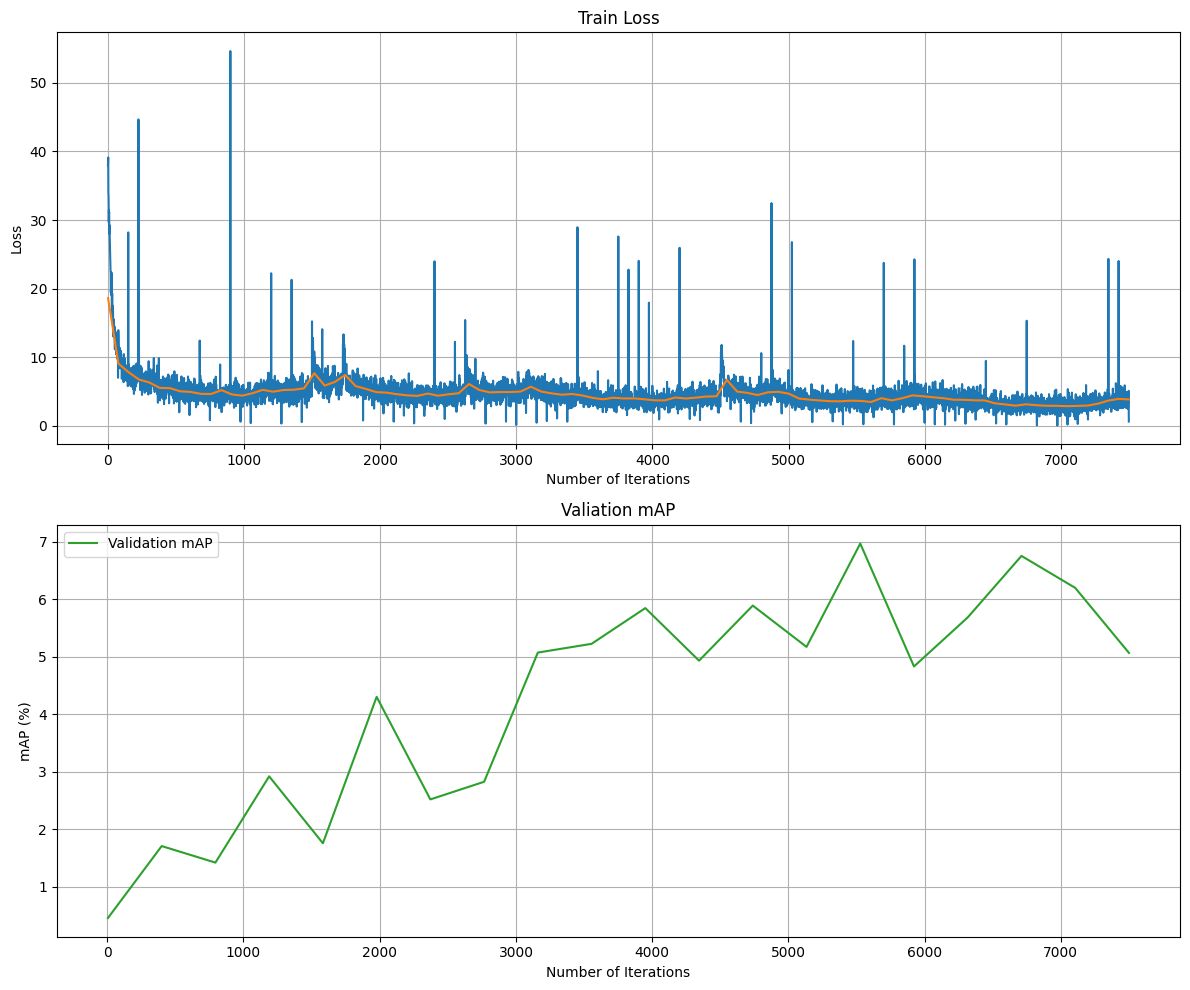

In [ ]:
runner.plot_loss(row_figsize=5)

In [ ]:
torch.save(model.state_dict(), "./detector/model.pt")

### Тестирование


In [ ]:
@torch.no_grad()
def predict(model, images, device, score_threshold=0.1, nms_threshold=0.5, max_boxes_per_cls=8, return_type='list'):
    """ Предсказание моделью для переданного набора изображений после фильтрации по score_threshold
    и применения NMS.

    Параметры
    --------
    images : torch.tensor, содержащий картинки для которых нужно сделать предсказание.
    Необходимые преобразования должны быть сделаны ДО. Внутри метода `predict` никаких преобразований
    не происходит.
    score_threshold : Все предсказания, с (confidence score * cls_probs) < score_threshold будут проигнорированны.
    nms_threshold : Предсказания, имеющие пересечение по IoU >= nms_threshold будут считаться одним предсказанием.
    max_boxes_per_cls : Максимальное количество ббоксов на изображение для одного класса после фильтрации по `score_threshold`.

    Returns
    -------
    final_predictions : List[dict], где каждый словарь содержащий следующие ключи:
        "boxes" : координаты ббоксов на i-ом изображении,
        "labels" : классы внутри ббоксов,
        "scores" : Confidence scores для ббоксов.
    """
    model.eval()
    images = images.to(device)
    outputs = model(images)
    final_predictions = _filter_predictions(outputs, score_threshold=score_threshold, nms_threshold=nms_threshold,
                                            max_boxes_per_cls=max_boxes_per_cls, return_type=return_type)
    return final_predictions

In [ ]:
def plot_predictions(images, predictions, figsize=(12, 3)):
    """ Рисуем по 3 предсказания на одной строке. """
    ncols = min(len(images), 3)
    for ix in range(0, len(images), ncols):
        _, axes = plt.subplots(1, ncols, figsize=figsize, tight_layout=True)
        for i, (ax, img) in enumerate(zip(axes, images[ix: ix+ncols])):
            img = img.cpu().permute(1, 2, 0).numpy()
            img = img * np.array(std).reshape(1, 1, -1) + \
                np.array(mean).reshape(1, 1, -1)
            img = np.ascontiguousarray((img * 255).astype(np.uint8))
            preds = predictions[ix + i]
            for bbox, label, score in zip(preds["boxes"], preds["labels"], preds["scores"]):
                color = class_colors[label]
                label = class_names[label]
                img = add_bbox(
                    img, bbox, label=f"Class {label}: {score:.2f}", color=color, normalized=False)
            ax.imshow(img)
            ax.set_xticks([])
            ax.set_yticks([])
        plt.show()
    plt.close()

In [ ]:
test_iter = iter(valid_dataloader)

In [ ]:
images, _ = next(test_iter)

In [ ]:
# model = Detector(pretrained_model, return_nodes).to(device)
# # model.load_state_dict(torch.load('./detector/model.pt'))

In [ ]:
score_threshold = 0.1
nms_threshold = 0.4

preds = predict(model, images, device=device,
                score_threshold=score_threshold, nms_threshold=nms_threshold)

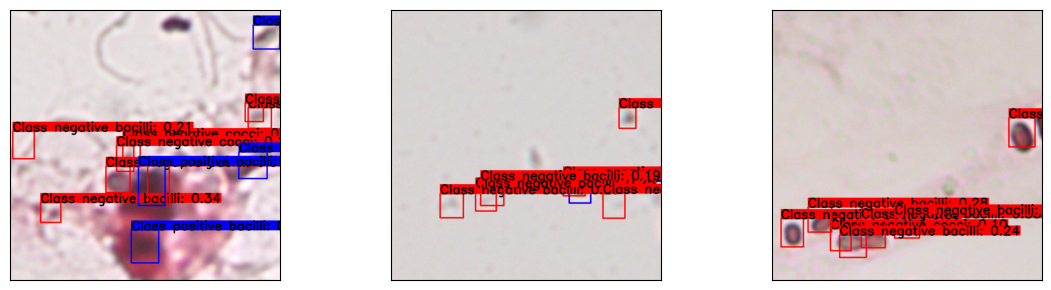

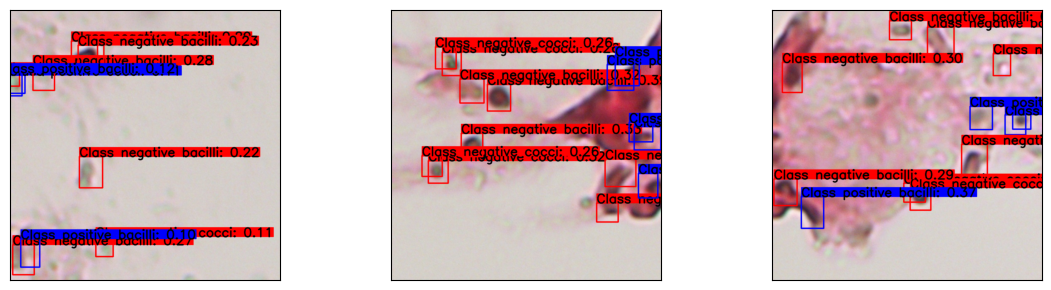

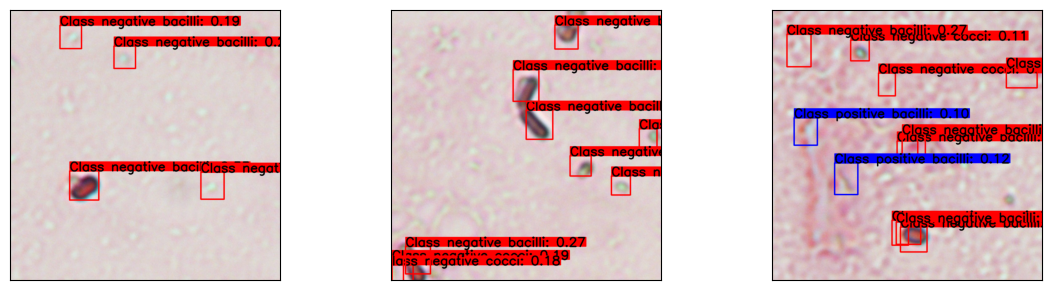

In [ ]:
plot_predictions(images, preds)

In [ ]:
runner.validate()

0.0506584607064724